In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
plt.style.use('fivethirtyeight')

In [2]:
#read data
df = pd.read_csv('office.csv',parse_dates=['Order Date'])

In [3]:
df.head()

Order Date    Sales
0 2014-01-03   16.448
1 2014-01-04  288.060
2 2014-01-05   19.536
3 2014-01-06  685.340
4 2014-01-07   10.430

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  1148 non-null   datetime64[ns]
 1   Sales       1148 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.1 KB


In [5]:
df.describe()

Sales
count   1148.000000
mean     626.347589
std      995.566806
min        1.788000
25%       80.853500
50%      284.455000
75%      744.390000
max    10142.354000

In [6]:
### Lets do data processing


# noting the easrlist and last recorded dates
start = df['Order Date'].min()
end = df['Order Date'].max()
print('start =',start, '\nend = ',end)

start = 2014-01-03 00:00:00 
end =  2017-12-30 00:00:00


<AxesSubplot:xlabel='Order Date'>

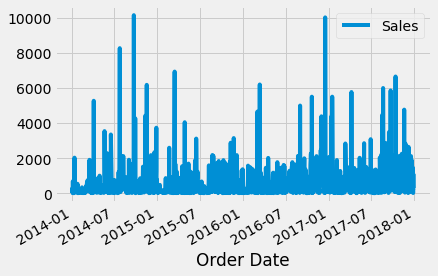

In [7]:
office_df = df.sort_values('Order Date')
office_df = office_df.groupby('Order Date')['Sales'].sum().reset_index()
#setting order date as index
office_df = office_df.set_index('Order Date')
office_df.plot()

<AxesSubplot:xlabel='Order Date'>

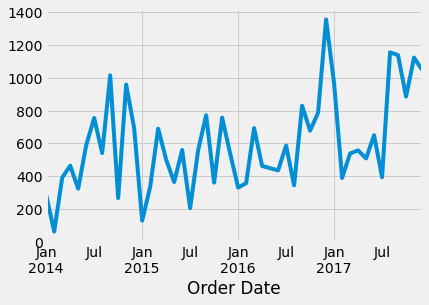

In [8]:
#since there are numerous sales in each month, let's resample the data into tatal monthly sales of furniture and save this into a new variable 
m_office = office_df['Sales'].resample('M').mean()
m_office.plot()

In [9]:
#preform adf test
from statsmodels.tsa.stattools import adfuller
def test_stationariy(series):
    result = adfuller(series)
    print('adf statistics = ',result[0],'\np value =',result[1])

In [10]:
test_stationariy(m_office)

adf statistics =  -4.664633175077929 
p value = 9.801371572373145e-05


### lets perform ETS decomposition to under stand the ternd and seasonality componenets


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
office_decom = seasonal_decompose(m_office,model='addictive')

Text(0.5, 1.0, 'tech decomposition')

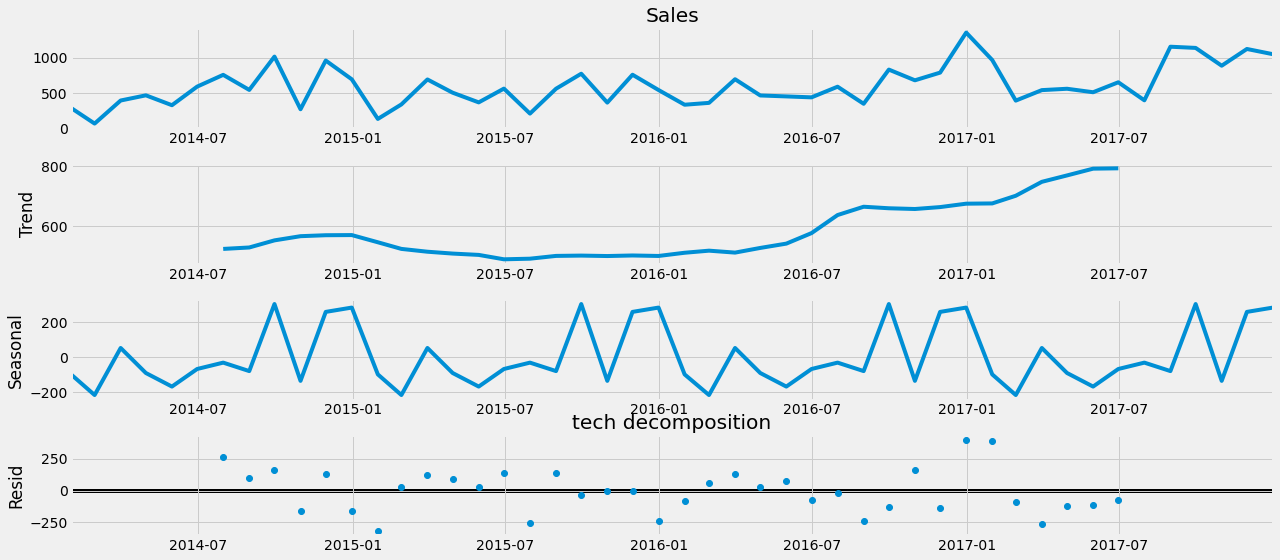

In [12]:
from pylab import rcParams
rcParams['figure.figsize']=18,8
office_decom.plot()
plt.title('tech decomposition')

# Time Series Analysis With SARIMA 

In [13]:
# splitting the data to train test
office_train = m_office[:36]
office_test = m_office[36:]

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


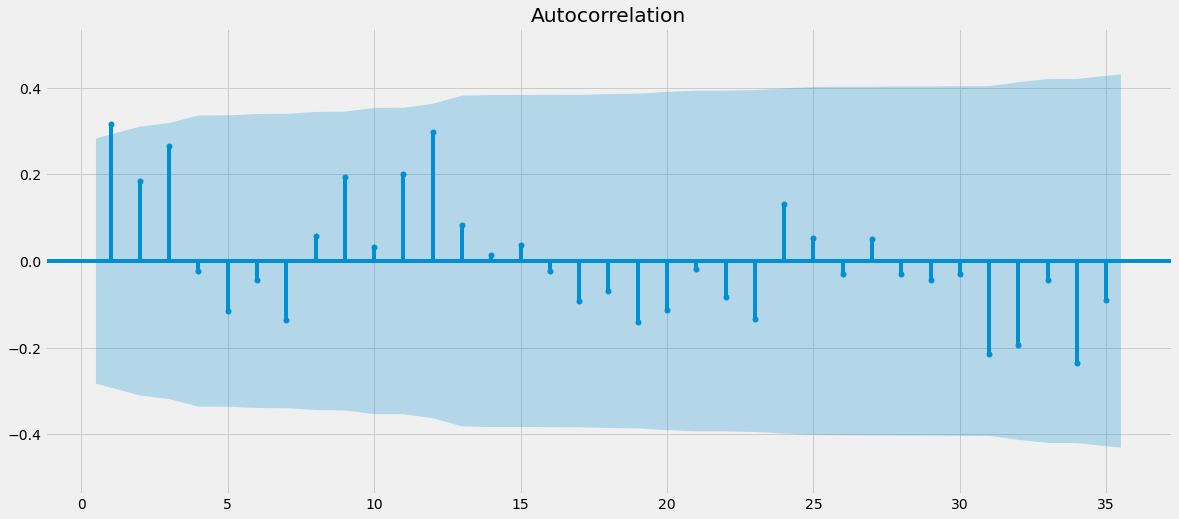

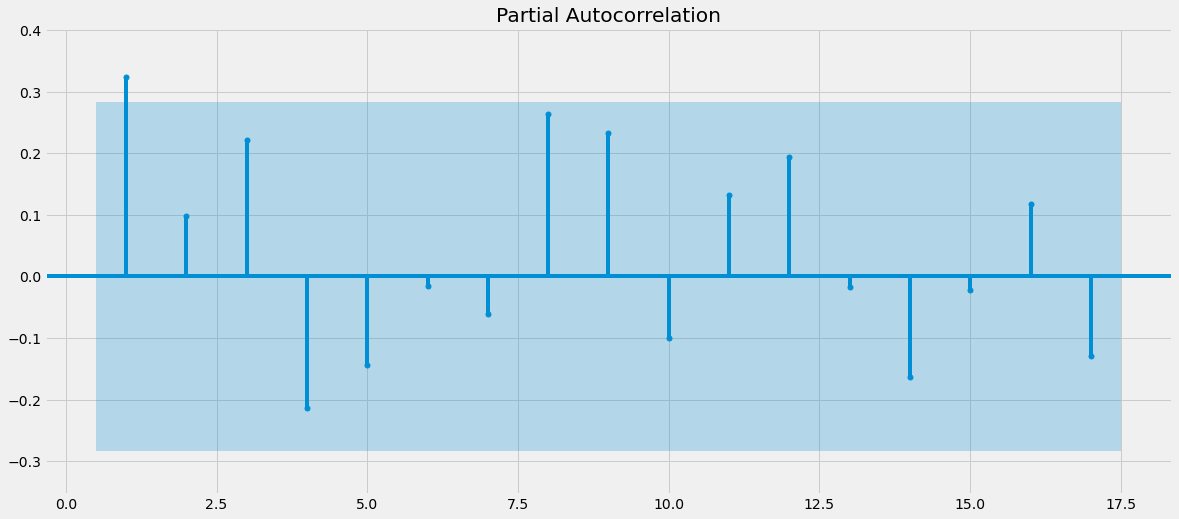

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(m_office,zero = 0, auto_ylims= 1, lags = 35);
plot_pacf(m_office,zero = 0, auto_ylims= 1);

In [23]:
# applying auto arima to get the best order
from pmdarima import auto_arima
office_order = auto_arima(office_train,m = 12,seasonal = True,trace=True,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=506.418, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=505.239, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=507.256, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=564.658, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=508.203, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=508.428, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=505.756, Time=0.40 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=507.223, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=503.281, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=503.443, Time=0.45 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=503.537, Time=0.41 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=505.380, Time=0.19 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AI

In [24]:
office_order.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -248.641
Date:                  Wed, 30 Nov 2022   AIC                            503.281
Time:                          17:37:00   BIC                            508.032
Sample:                      01-31-2014   HQIC                           504.939
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    287.8974    144.694      1.990      0.047       4.303     571.492
ar.S.L12       0.4778      0.257      1.861      0.063      -0.026       0.981
sigma2      5.359e+04   8978.245      5.969      0.000     3.6e+04    7.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                14.84
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.95
Prob(H) (two-sided):                  0.73   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
#training the model
from statsmodels.tsa.statespace.sarimax import SARIMAX
office_mdl = SARIMAX(office_train,order=(0, 0, 0),seasonal_order=(1, 0, 0, 12),enforce_invertibility=False)

In [26]:
office_model = office_mdl.fit()
office_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -261.624
Date:                  Wed, 30 Nov 2022   AIC                            527.248
Time:                          17:37:24   BIC                            530.415
Sample:                      01-31-2014   HQIC                           528.353
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9115      0.062     14.669      0.000       0.790       1.033
sigma2      6.646e+04   1.32e+04      5.053      0.000    4.07e+04    9.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 9.87
Prob(Q):                              0.85   Prob(JB):                         0.01
Heteroskedasticity (H):               1.60   Skew:                             0.40
Prob(H) (two-sided):                  0.43   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
resids = office_model.resid

Text(0, 0.5, 'Error')

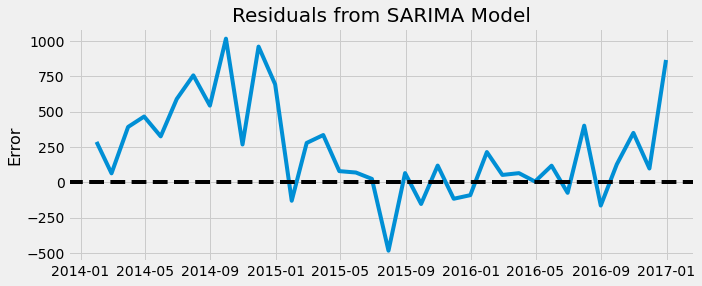

In [35]:
plt.figure(figsize=(10,4))
plt.plot(resids)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [36]:
# predicting
start_date = office_test.index[0]
end_date = office_test.index[-1]
pred_office = office_model.predict(start = start_date, end = end_date)

In [37]:
#evaluating
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse
print('mae:',mean_absolute_error(office_test,pred_office),'\nrmse:',rmse(office_test,pred_office))

mae: 294.7661405116416 
rmse: 375.7043038149033


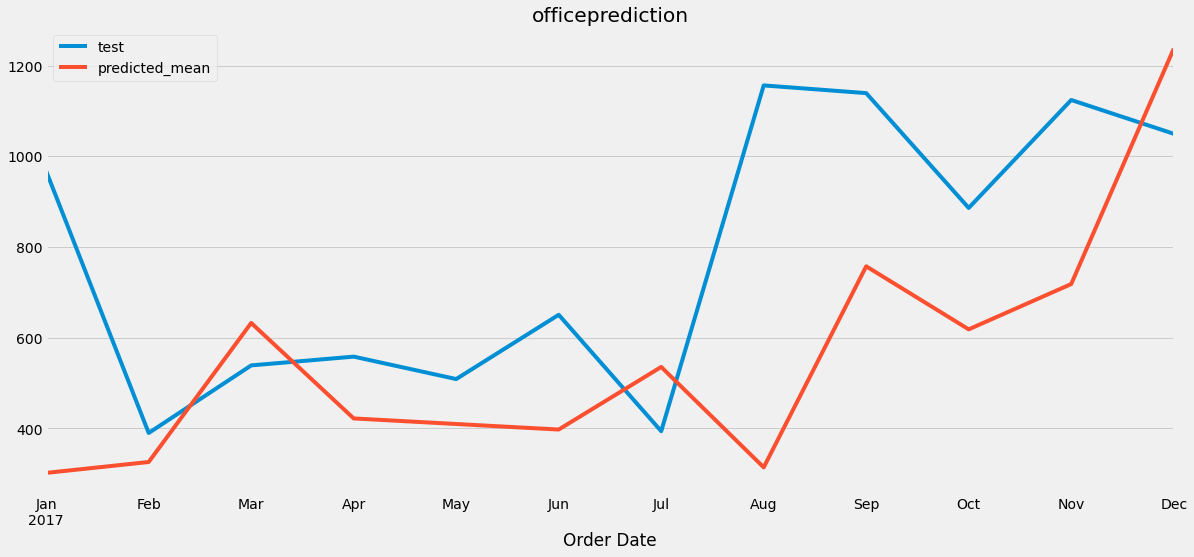

In [38]:
office_test.plot(label= 'test')
pred_office.plot()
plt.title("officeprediction")
plt.legend()

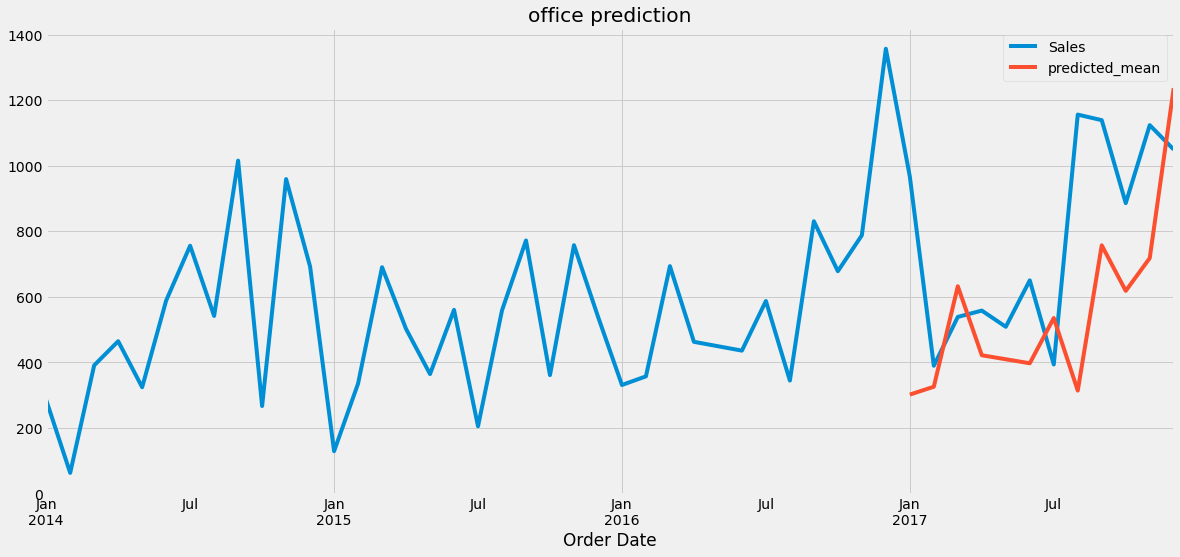

In [39]:
m_office.plot()
pred_office.plot()
plt.title("office prediction")
plt.legend()

# forecasting

In [40]:
final_office_model = SARIMAX(m_office,order=(0, 0, 0),seasonal_order=(1, 0, 0, 12),enforce_invertibility=False)
office_model_final = final_office_model.fit()
forecast_office = office_model_final.forecast(steps = 12)

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


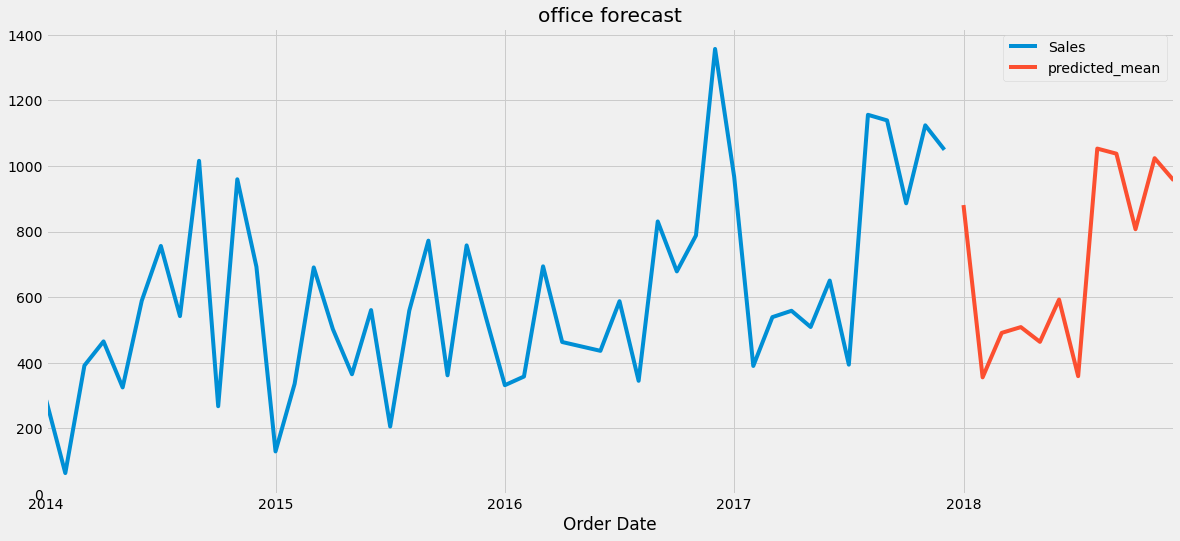

In [41]:
m_office.plot()
forecast_office.plot()
plt.title("office forecast")
plt.legend()

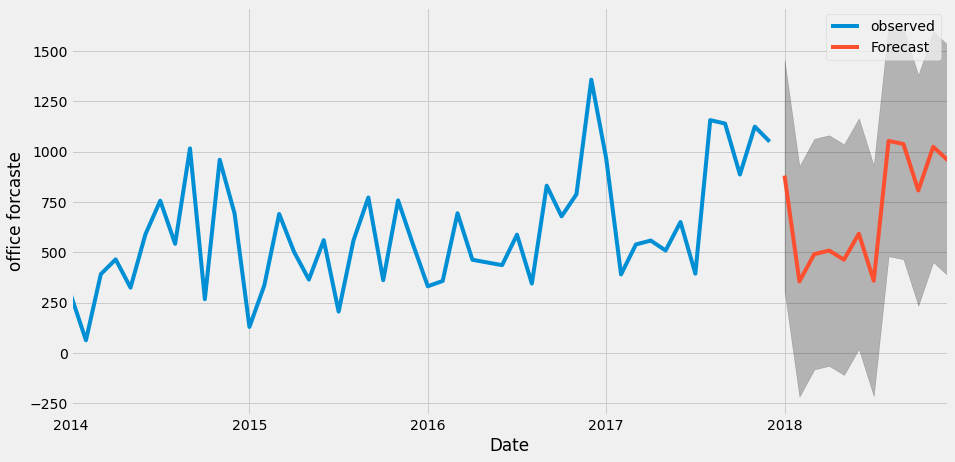

In [42]:
pred_off = office_model_final.get_forecast(steps=12)
pred_ci_furn = pred_off.conf_int()
ax = m_office.plot(label='observed',figsize=(14,7))
pred_off.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furn.index,
               pred_ci_furn.iloc[:,0],
               pred_ci_furn.iloc[:,1],color='k',alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('office forcaste')
plt.legend()
plt.show()

# Time series modelling with prophet

In [44]:
p_office = pd.DataFrame({'y':m_office, 'ds': m_office.index})
p_office.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       48 non-null     float64       
 1   ds      48 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [46]:
# splitting the data to train test
train = p_office[:36]
test = p_office[36:]

In [48]:
# Now lets predic with the model
start_date = office_test.index[0]
end_date =office_test.index[-1]
prophet_model = Prophet()
prophet_model.fit(train)

17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
forecast_date = prophet_model.make_future_dataframe(periods=12,freq='M')
prophet_predict = prophet_model.predict(forecast_date)
prophet_predict

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2014-01-31  528.688634   -43.516022   228.165858   528.688634   528.688634   
1  2014-02-28  529.825357    98.647189   386.336496   529.825357   529.825357   
2  2014-03-31  531.083872   430.331629   707.360859   531.083872   531.083872   
3  2014-04-30  532.301789   304.144296   600.286767   532.301789   532.301789   
4  2014-05-31  533.560304   200.605167   500.334162   533.560304   533.560304   
5  2014-06-30  534.778222   389.857720   671.770858   534.778222   534.778222   
6  2014-07-31  536.036737   321.936608   601.925677   536.036737   536.036737   
7  2014-08-31  537.295251   360.909025   644.202891   537.295251   537.295251   
8  2014-09-30  538.513169   726.953937  1009.947159   538.513169   538.513169   
9  2014-10-31  539.771684   252.678761   543.371778   539.771684   539.771684   
10 2014-11-30  540.989601   705.790259   987.479942   540.989601   540.989601   
11 2014-12-31  542.248116   628.683891   915.217297   542.248116   542.248116   
12 2015-01-31  543.506631   104.311770   384.432186   543.506631   543.506631   
13 2015-02-28  544.643354   125.972705   412.402672   544.643354   544.643354   
14 2015-03-31  545.901869   432.892973   724.926469   545.901869   545.901869   
15 2015-04-30  547.119786   333.591563   615.783698   547.119786   547.119786   
16 2015-05-31  548.378301   159.926760   455.359150   548.378301   548.378301   
17 2015-06-30  549.596219   442.752380   714.674177   549.596219   549.596219   
18 2015-07-31  550.854733   247.666760   527.309502   550.854733   550.854733   
19 2015-08-31  552.113248   468.979413   753.454603   552.113248   552.113248   
20 2015-09-30  553.331166   763.603260  1061.860029   553.331166   553.331166   
21 2015-10-31  554.589681   221.345276   498.823757   554.589681   554.589681   
22 2015-11-30  555.807638   786.894071  1072.672397   555.807638   555.807638   
23 2015-12-31  557.066194   436.835474   733.251011   557.066194   557.066194   
24 2016-01-31  558.324755   263.656908   544.630020   558.324755   558.324755   
25 2016-02-29  559.502119   108.789096   393.440243   559.502119   559.502119   
26 2016-03-31  560.760680   483.262801   762.697256   560.760680   560.760680   
27 2016-04-30  561.978643   341.353048   630.130481   561.978643   561.978643   
28 2016-05-31  563.237204   333.606445   614.733040   563.237204   563.237204   
29 2016-06-30  564.455167   341.835167   636.777556   564.455167   564.455167   
30 2016-07-31  565.713728   549.695065   832.101522   565.713728   565.713728   
31 2016-08-31  566.972290   200.571864   476.294704   566.972290   566.972290   
32 2016-09-30  568.190252   682.890145   968.878936   568.190252   568.190252   
33 2016-10-31  569.448814   403.381251   689.715102   569.448814   569.448814   
34 2016-11-30  570.666776   576.911468   874.141750   570.666776   570.666776   
35 2016-12-31  571.925338  1087.752701  1369.507316   571.925338   571.925338   
36 2017-01-31  573.183899  -129.113421   155.373202   573.183898   573.183901   
37 2017-02-28  574.320664   134.701266   419.701341   574.320659   574.320669   
38 2017-03-31  575.579226   481.185423   771.355461   575.579216   575.579235   
39 2017-04-30  576.797188   364.613015   642.262244   576.797174   576.797203   
40 2017-05-31  578.055750   293.434803   578.837050   578.055730   578.055770   
41 2017-06-30  579.273712   392.863815   672.026440   579.273686   579.273738   
42 2017-07-31  580.532274   464.468046   745.815447   580.532241   580.532307   
43 2017-08-31  581.790835   300.723783   588.905365   581.790796   581.790875   
44 2017-09-30  583.008798   744.695624  1021.447088   583.008752   583.008846   
45 2017-10-31  584.267359   364.349616   654.822166   584.267304   584.267415   
46 2017-11-30  585.485322   674.278861   966.479926   585.485258   585.485386   
47 2017-12-31  586.743883   889.158271  1172.265113   586.743812   586.743957   

    additive_terms  additive_terms_lower 

In [50]:
pred_prof = prophet_predict[['yhat','ds']][36:]
pred_prof.set_index('ds',inplace=True)

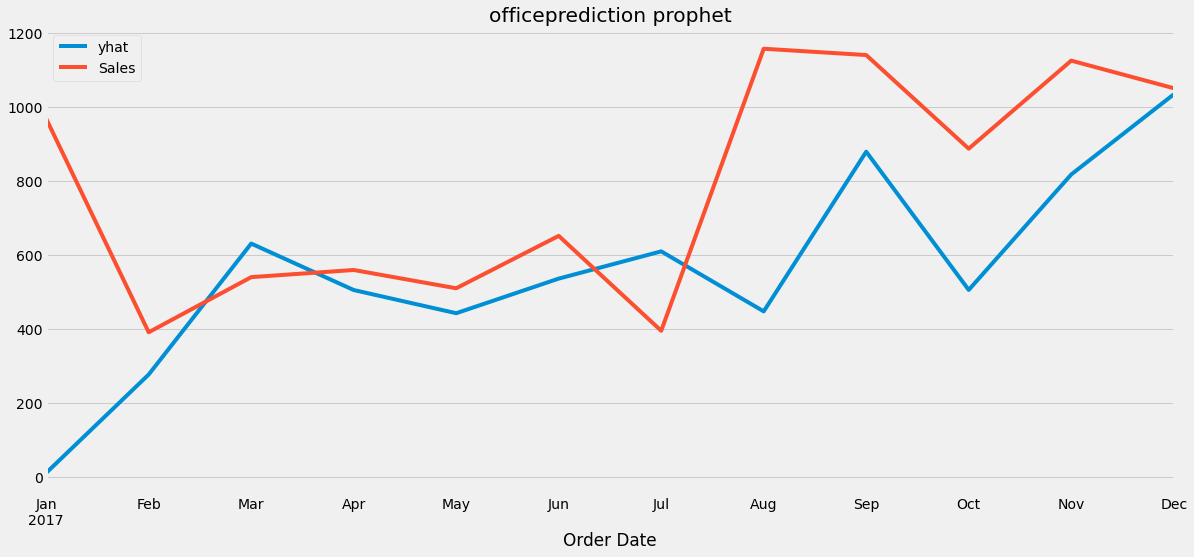

In [57]:
pred_prof.plot()
office_test.plot()
plt.title("officeprediction prophet")
plt.legend()

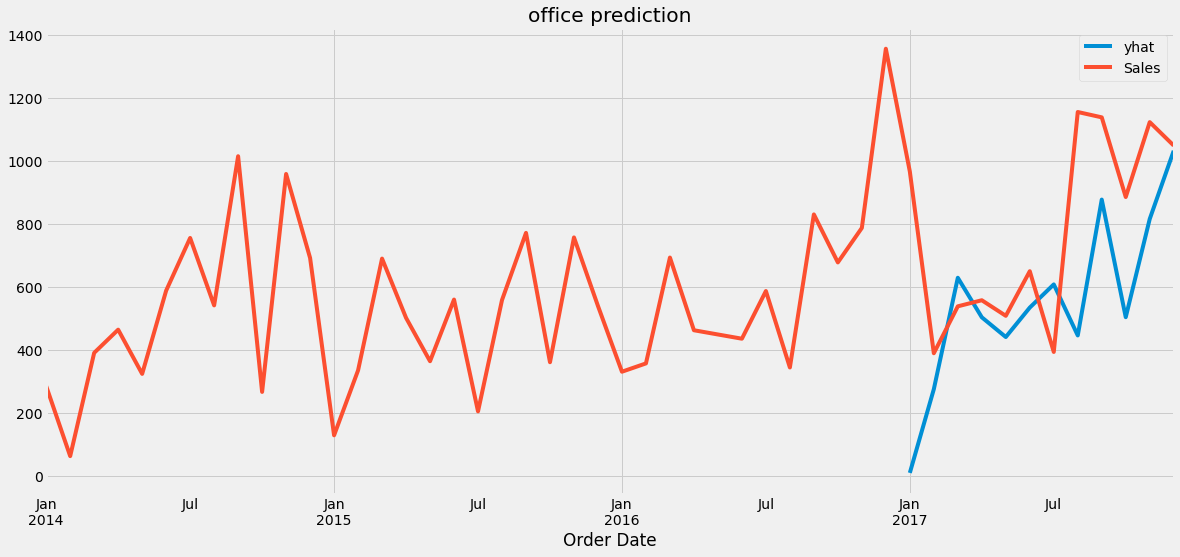

In [58]:
pred_prof.plot()
m_office.plot()
plt.title("office prediction")
plt.legend()

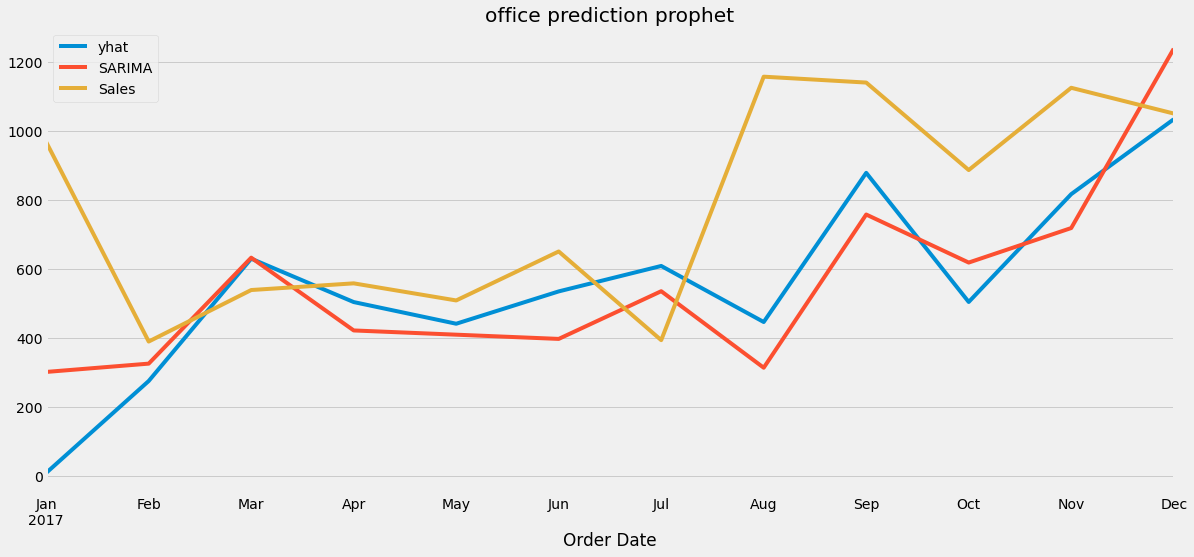

In [59]:
pred_prof.plot(label = 'Prophet')
pred_office.plot(label = 'SARIMA')
office_test.plot(label = 'Sales')
plt.title("office prediction prophet")
plt.legend()
plt.show()

## Forecasting

In [60]:
prophet_model = Prophet()
prophet_model.fit(p_office)

17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
forecast_date = prophet_model.make_future_dataframe(periods=12,freq='M')
prophet_forecast = prophet_model.predict(forecast_date)
prophet_forecast

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2014-01-31  335.262024   113.542461   529.675347   335.262024   335.262024   
1  2014-02-28  342.198015   -12.472954   385.134130   342.198015   342.198015   
2  2014-03-31  349.877147   270.768275   677.748309   349.877147   349.877147   
3  2014-04-30  357.308566   168.174371   567.857964   357.308566   357.308566   
4  2014-05-31  364.987698    51.878385   456.246609   364.987698   364.987698   
5  2014-06-30  372.419117   245.388870   636.191255   372.419117   372.419117   
6  2014-07-31  380.098250   108.708914   508.166998   380.098250   380.098250   
7  2014-08-31  387.777382   326.258569   740.763086   387.777382   387.777382   
8  2014-09-30  395.208801   611.064357  1025.516333   395.208801   395.208801   
9  2014-10-31  402.887933   197.949361   591.610525   402.887933   402.887933   
10 2014-11-30  410.319352   618.652235  1034.967313   410.319352   410.319352   
11 2014-12-31  417.998484   508.546053   905.535110   417.998484   417.998484   
12 2015-01-31  425.677617   133.410189   536.000980   425.677617   425.677617   
13 2015-02-28  432.613607   172.135762   569.879800   432.613607   432.613607   
14 2015-03-31  440.292740   410.385171   810.946294   440.292740   440.292740   
15 2015-04-30  447.724158   290.494516   681.770708   447.724158   447.724158   
16 2015-05-31  455.403291    76.157489   493.899122   455.403291   455.403291   
17 2015-06-30  462.834710   345.952097   737.757670   462.834710   462.834710   
18 2015-07-31  470.513842   118.168902   533.283822   470.513842   470.513842   
19 2015-08-31  478.192975   450.208453   856.745937   478.192975   478.192975   
20 2015-09-30  485.624423   758.512797  1157.549089   485.624423   485.624423   
21 2015-10-31  493.303586   260.550120   651.266277   493.303586   493.303586   
22 2015-11-30  500.735034   850.897852  1256.726092   500.735034   500.735034   
23 2015-12-31  508.414197   473.519936   879.159684   508.414197   508.414197   
24 2016-01-31  516.093360   159.478248   555.755122   516.093360   516.093360   
25 2016-02-29  523.279285    -7.157453   423.012182   523.279285   523.279285   
26 2016-03-31  530.960851   351.234290   746.737966   530.960851   530.960851   
27 2016-04-30  538.394624   297.341619   702.078798   538.394624   538.394624   
28 2016-05-31  546.076189   334.419468   771.978159   546.076189   546.076189   
29 2016-06-30  553.509963   386.679283   794.358459   553.509963   553.509963   
30 2016-07-31  561.191528   438.208514   852.801463   561.191528   561.191528   
31 2016-08-31  568.873094   442.732884   844.255731   568.873094   568.873094   
32 2016-09-30  576.306867   714.819086  1129.001680   576.306867   576.306867   
33 2016-10-31  583.988433   448.834693   859.315539   583.988433   583.988433   
34 2016-11-30  591.422206   553.636494   960.766402   591.422206   591.422206   
35 2016-12-31  599.103772   914.680775  1330.961623   599.103772   599.103772   
36 2017-01-31  606.785337   488.447299   865.499863   606.785337   606.785337   
37 2017-02-28  613.723526   185.966657   584.667185   613.723526   613.723526   
38 2017-03-31  621.405091   493.528750   885.492121   621.405091   621.405091   
39 2017-04-30  628.838864   424.036064   834.949120   628.838864   628.838864   
40 2017-05-31  636.520430   380.440902   779.710729   636.520430   636.520430   
41 2017-06-30  643.954203   474.088100   875.704659   643.954203   643.954203   
42 2017-07-31  651.635769   456.487958   851.371512   651.635769   651.635769   
43 2017-08-31  659.317334   544.657469   973.714743   659.317334   659.317334   
44 2017-09-30  666.751108   852.043404  1242.691102   666.751108   666.751108   
45 2017-10-31  674.432673   492.124151   902.662803   674.432673   674.432673   
46 2017-11-30  681.866446   792.146425  1178.735315   681.866446   681.866446   
47 2017-12-31  689.548012   906.467878  1323.735272   689.548012   689.548012   
48 2018-01-31  697.229578   483.482624   8

In [62]:
from prophet.plot import plot_plotly, plot_components_plotly

In [63]:
plot_plotly(prophet_model, prophet_forecast)

In [64]:
plot_components_plotly(prophet_model , prophet_forecast)